<a href="https://colab.research.google.com/github/rndrpp/Tabular-Playground-Series---Sep-2022/blob/main/Tabular_Playground_Series_Sep_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective: Predicting a full year worth of sales for 4 items from two competing stores located in six different countries

To do:

**EDA**:


**Preprocessing**:

Cleaning

Feature Engineering
- Column season, weekend, holiday from date

**Training Model**:
- Let's try Linear Regression, RF Regression, XGBoost

Note:
- Pay attention to season, weekend, holiday

In [ ]:
# !pip install kaggle

In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
# !kaggle competitions download -c tabular-playground-series-sep-2022

In [ ]:
# !unzip tabular-playground-series-sep-2022

In [ ]:
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

sns.set_style("darkgrid")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/Tabular Playground Series - Sep 2022.ipynb/train.csv', parse_dates=['date'], index_col=0)

test = pd.read_csv('/content/drive/MyDrive/Kaggle/Tabular Playground Series - Sep 2022.ipynb/test.csv', parse_dates=['date'], index_col=0)

In [ ]:
train.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [ ]:
test.head()

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.2+ MB


In [ ]:
print('Train start date:', train['date'].min())
print('Train end date:', train['date'].max())
print('Test start date:', test['date'].min())
print('Test end date:', test['date'].max())

Train start date: 2017-01-01 00:00:00
Train end date: 2020-12-31 00:00:00
Test start date: 2021-01-01 00:00:00
Test end date: 2021-12-31 00:00:00


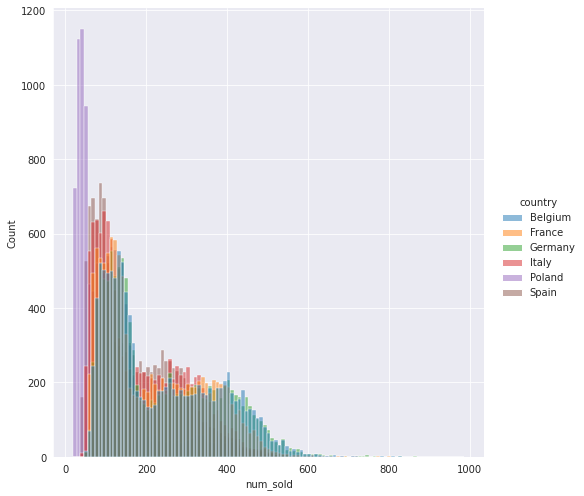

In [ ]:
sns.displot(train, x = 'num_sold', hue = 'country', height = 7)

plt.show();

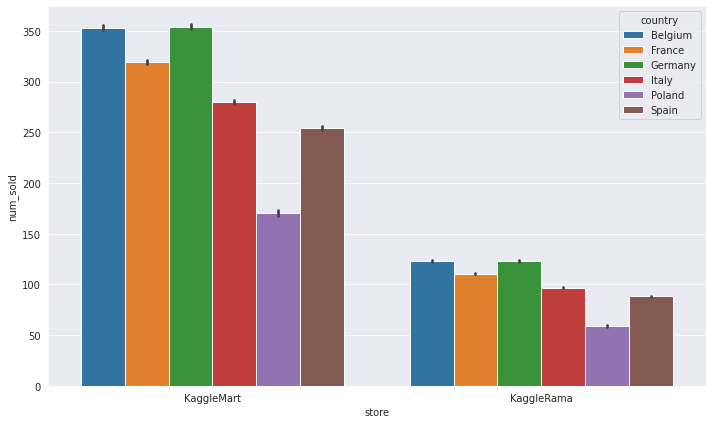

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

sns.barplot(data=train, x='store', y='num_sold', hue='country')

plt.tight_layout()
plt.show();

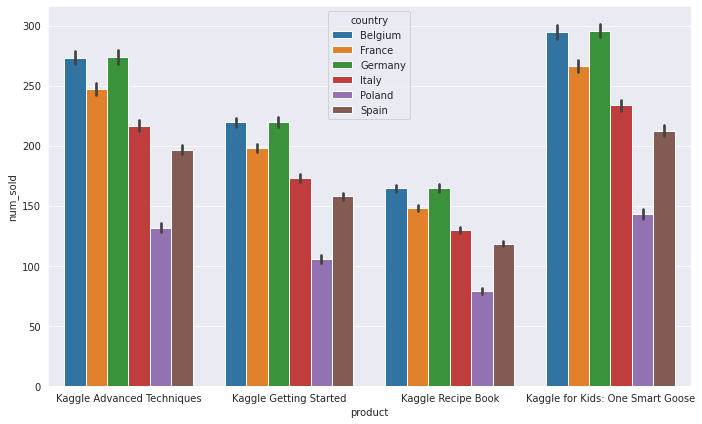

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

sns.barplot(data=train, x='product', y='num_sold', hue='country')

plt.tight_layout()
plt.show();

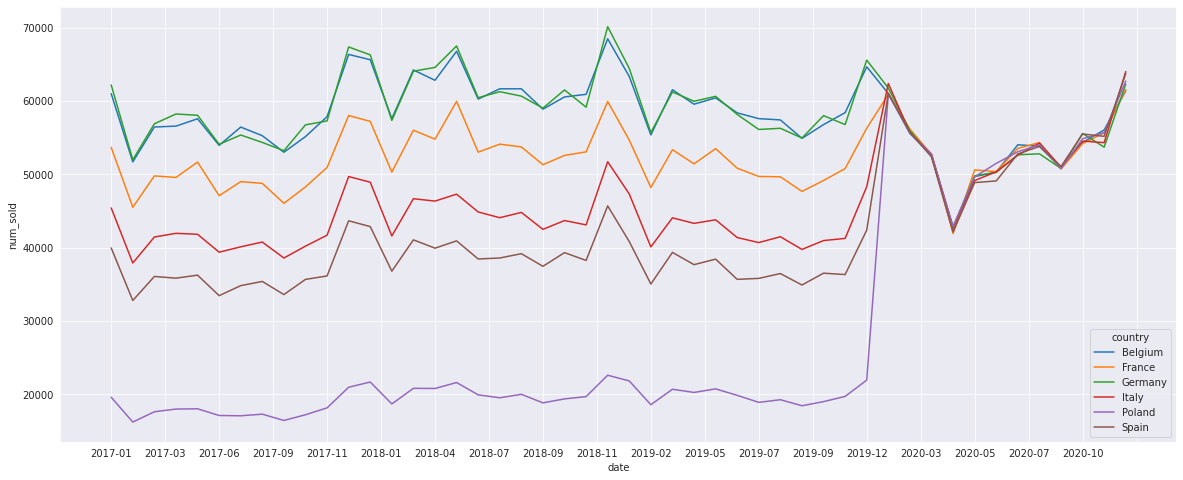

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

ax = sns.lineplot(data=train.groupby([
        train.date.dt.strftime('%Y-%m'),
        train.country
    ])['num_sold'].sum().reset_index(), x = 'date', y='num_sold', hue = 'country')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25))

plt.show();

# Preprocessing

In [ ]:
print('Train missing values:')
print(train.isnull().mean().sort_values(ascending = False) * 100)

print('Test missing values:')
print(test.isnull().mean().sort_values(ascending = False) * 100)

Train missing values:
date        0.0
country     0.0
store       0.0
product     0.0
num_sold    0.0
dtype: float64
Test missing values:
date       0.0
country    0.0
store      0.0
product    0.0
dtype: float64


In [ ]:
print('Train duplicated values:', train.duplicated().sum())
print('Test duplicated values:', test.duplicated().sum())

Train duplicated values: 0
Test duplicated values: 0


In [ ]:
train_processed = train.copy()

In [ ]:
def preprocessing(df):
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day_of_week'] = df['date'].dt.dayofweek
  df['day_of_month'] = df['date'].dt.day
  df['day_of_year'] = df['date'].dt.dayofyear
  df['weekday'] = df['date'].dt.weekday
  df['is_weekend'] = df['weekday'].astype(int) > 4
  # df['is_weekend'] = df['is_weekend'].astype
  df['is_pandemic'] = df['year'].astype(int) >= 2020
  # df['is_pandemic'] = df['is_pandemic'].astype
  
  df['is_special'] = (df['month']*100+df['day_of_year']).isin([101,102,1228,1229,1230,1231])
  df["month_cos"] = np.cos(df['month'] * (2 * np.pi / 12))
  df["month_sin"] = np.sin(df['month'] * (2 * np.pi / 12))

  df.drop('date', axis=1, inplace = True)

In [ ]:
preprocessing(train_processed)

In [ ]:
train_processed.sample(5)

,country,store,product,num_sold,year,month,day_of_week,day_of_month,day_of_year,weekday,is_weekend,is_pandemic,is_special,month_cos,month_sin
row_id,,,,,,,,,,,,,,,
18380,Spain,KaggleRama,Kaggle Advanced Techniques,97,2018,1,3,18,18,3,False,False,False,8.660254e-01,0.500000
36147,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,407,2019,1,3,24,24,3,False,False,False,8.660254e-01,0.500000
47574,Belgium,KaggleRama,Kaggle Recipe Book,77,2019,9,3,19,262,3,False,False,False,-1.836970e-16,-1.000000
4110,Italy,KaggleRama,Kaggle Recipe Book,54,2017,3,0,27,86,0,False,False,False,6.123234e-17,1.000000
54661,Poland,KaggleRama,Kaggle Getting Started,93,2020,2,3,13,44,3,False,True,False,5.000000e-01,0.866025


In [ ]:
# from scipy.stats import norm, skew #for some statistics

# x = train_processed['num_sold']

# print(f"Skewness of our target data before normalization : {skew(x)}")

In [ ]:
# from scipy.stats import probplot, boxcox
# from scipy.special import inv_boxcox

# fitted_data, fitted_lambda = boxcox(x)

In [ ]:
# print(f"Skewness of our target data before normalization : {skew(fitted_lambda)}")

In [ ]:
# train_processed['num_sold'] = fitted_data

# Modeling

In [ ]:
X = train_processed.drop('num_sold', axis=1)
# X = pd.get_dummies(X)
y = train_processed ['num_sold']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   country       70128 non-null  category
 1   store         70128 non-null  category
 2   product       70128 non-null  category
 3   year          70128 non-null  int64   
 4   month         70128 non-null  int64   
 5   day_of_week   70128 non-null  int64   
 6   day_of_month  70128 non-null  int64   
 7   day_of_year   70128 non-null  int64   
 8   weekday       70128 non-null  int64   
 9   is_weekend    70128 non-null  category
 10  is_pandemic   70128 non-null  category
 11  is_special    70128 non-null  category
 12  month_cos     70128 non-null  float64 
 13  month_sin     70128 non-null  float64 
dtypes: category(6), float64(2), int64(6)
memory usage: 7.2 MB


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

In [ ]:
pipelines = {
    'xgb': make_pipeline(StandardScaler(), XGBRegressor(random_state=42)),
    'lgbm': make_pipeline(StandardScaler(), LGBMRegressor(objective ='regression',metric = 'mae',random_state=42))
    # 'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42)),
}

In [ ]:
grid = {
    'lgbm': {
        'lgbmregressor__n_estimators':[700,],
         'lgbmregressor__max_depth':[7,],
         'lgbmregressor__num_leaves':[64,],
         'lgbmregressor__learning_rate':[0.1,],
         'lgbmregressor__min_child_samples': [20,],
         'lgbmregressor__min_child_weight': [0.001,],
         'lgbmregressor__colsample_bytree': [0.5,],
         'lgbmregressor__subsample': [0.6633806094241483,],
         'lgbmregressor__reg_alpha': [0.05,], 
         'lgbmregressor__reg_lambda': [0],

    },
    # 'rf': {
    #     'randomforestregressor__n_estimators':[300],
    #     'randomforestregressor__criterion':['squared_error', 'absolute_error'],
    #     'randomforestregressor__max_depth':[7],
    #     'randomforestregressor__max_features':['auto','sqrt'],
        
    # }, 
    'xgb': {
        'xgbregressor__n_estimators':[300,],
        'xgbregressor__max_depth':[7],
        'xgbregressor__learning_rate':[0.1],
        'xgbregressor__eta':[0.2]
    }
}

In [ ]:
fit_models = {}

for clf, pipeline in pipelines.items():
    print(f'Training the {clf} model.')
   
    model = GridSearchCV(pipeline, grid[clf], verbose = 1, 
                                cv = 5,
                                scoring='neg_mean_absolute_error', 
                                n_jobs=-1)
  
    model.fit(X_train, y_train)
  
    fit_models[clf] = model

Training the xgb model.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training the lgbm model.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
def smape(y_valid, y_pred):
    denominator = (np.abs(y_valid) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_valid - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [ ]:
for clf, model in fit_models.items(): 
    y_pred = model.predict(X_valid)
    score = smape(y_valid,y_pred)
    print(f'{clf}: SMAPE {score}')

xgb: SMAPE 1.2084564001963323
lgbm: SMAPE 1.183493042161343


- xgb: SMAPE 4.4104661008119175
- lgbm: SMAPE 4.4518679268095545

- xgb: SMAPE 1.201822387810703
- lgbm: SMAPE 1.2018929034921908
- lgbm: SMAPE 1.187539247603815

In [ ]:
y = test.copy()

preprocessing(y)

# y_test = pd.get_dummies(y)

In [ ]:
continuous_cols = list(y.select_dtypes(include='number').columns)
# continuous_cols.remove('num_sold')
continuous_cols

['year',
 'month',
 'day_of_week',
 'day_of_month',
 'day_of_year',
 'weekday',
 'month_cos',
 'month_sin']

In [ ]:
y_test = y.copy()

In [ ]:
y_pred_test = inv_boxcox(fit_models['lgbm'].predict(y_test), fitted_lambda)

In [ ]:
submission = pd.DataFrame({'num_sold':y_pred_test}, index=test.index)
submission

,num_sold
row_id,
70128,562.929340
70129,418.684783
70130,370.657384
70131,615.094336
70132,194.992853
...,...
87643,349.378355
87644,114.379113
87645,89.226219


In [ ]:
submission.to_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c tabular-playground-series-sep-2022 -f "submission.csv" -m "lgbm 6" 

100% 418k/418k [00:00<00:00, 1.87MB/s]
Successfully submitted to Tabular Playground Series - Sep 2022

In [ ]:
fit_models['xgb'].best_params_

{'xgbregressor__booster': 'gbtree',
 'xgbregressor__eta': 0.2,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 7,
 'xgbregressor__n_estimators': 300}

In [ ]:
fit_models['lgbm'].best_params_

{'lgbmregressor__colsample_bytree': 0.5,
 'lgbmregressor__learning_rate': 0.1,
 'lgbmregressor__max_depth': 7,
 'lgbmregressor__min_child_samples': 20,
 'lgbmregressor__min_child_weight': 0.001,
 'lgbmregressor__n_estimators': 700,
 'lgbmregressor__num_leaves': 64,
 'lgbmregressor__reg_alpha': 0.05,
 'lgbmregressor__reg_lambda': 0,
 'lgbmregressor__subsample': 0.6633806094241483}

In [ ]:
import pickle

with open('xgb_tabular_sep22.pkl', 'wb') as f: 
  pickle.dump(fit_models['xgb'], f)


In [ ]:
with open('gradientboosted.pkl', 'rb') as f: 
  reloaded_model = pickle.load(f)

In [ ]:
!pip install --pre --quie markupsafe==2.0.1 Jinja2

In [ ]:
!pip install --pre --quiet pycaret

In [ ]:
from pycaret.regression import *

In [ ]:
s = setup(train_processed, target='num_sold')

,Description,Value
0,session_id,5307
1,Target,num_sold
2,Original Data,"(70128, 15)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(49089, 40)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='num_sold',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
              

In [ ]:
best_model = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,9.995200e+00,2.387344e+02,1.544650e+01,9.852000e-01,0.0654,5.160000e-02,21.404
lightgbm,Light Gradient Boosting Machine,9.941500e+00,2.229602e+02,1.492720e+01,9.862000e-01,0.0704,5.450000e-02,0.558
et,Extra Trees Regressor,1.129690e+01,3.247508e+02,1.800680e+01,9.799000e-01,0.0755,5.820000e-02,21.345
dt,Decision Tree Regressor,1.316250e+01,4.104982e+02,2.025640e+01,9.746000e-01,0.0859,6.760000e-02,0.352
gbr,Gradient Boosting Regressor,1.873660e+01,8.060744e+02,2.837890e+01,9.501000e-01,0.2111,1.108000e-01,5.242
huber,Huber Regressor,4.043210e+01,3.181673e+03,5.639070e+01,8.030000e-01,0.4497,2.861000e-01,1.977
lasso,Lasso Regression,4.112050e+01,3.196697e+03,5.652540e+01,8.020000e-01,0.4266,2.910000e-01,0.081
lr,Linear Regression,4.133750e+01,3.050539e+03,5.521830e+01,8.110000e-01,0.4791,3.162000e-01,0.387
br,Bayesian Ridge,4.140970e+01,3.062327e+03,5.532540e+01,8.103000e-01,0.4757,3.168000e-01,0.168
ridge,Ridge Regression,4.140950e+01,3.062182e+03,5.532410e+01,8.103000e-01,0.4757,3.168000e-01,0.043


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 4
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=5307, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
evaluate_model(best_model)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=5307, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
tuned_best_model = tune_model(best_model, optimize='MAPE')

INFO:logs:Initializing tune_model()
INFO:logs:tune_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=5307, verbose=0, warm_start=False), fold=None, round=4, n_iter=10, custom_grid=None, optimize=MAPE, custom_scorer=None, search_library=scikit-learn, search_algorithm=None, early_stopping=False, early_stopping_max_iters=10, choose_better=False, fit_kwargs=None, groups=None, return_tuner=False, verbose=True, tuner_verbose=True, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:23:48
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


INFO:logs:Copying training dataset
INFO:logs:Checking base model
INFO:logs:Base model : Random Forest Regressor
INFO:logs:Declaring metric variables
INFO:logs:Defining Hyperparameters
INFO:logs:Tuning with n_jobs=-1
INFO:logs:Initializing RandomizedSearchCV


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
evaluate_model(tuned_best_model)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=16, min_child_weight=0.001, min_split_gain=0.8,
              n_estimators=100, n_jobs=-1, num_leaves=80, objective=None,
              random_state=5307, reg_alpha=0.3, reg_lambda=0.01, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
evaluate_model(best_model)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=5307, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Kaggle/Tabular Playground Series - Sep 2022.ipynb/sample_submission.csv')

In [ ]:
predictions = predict_model(best_model, data=y)
predictions.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=5307, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,country,store,product,year,month,day_of_week,day_of_month,day_of_year,weekday,is_weekend,is_pandemic,is_special,month_cos,month_sin,Label
row_id,,,,,,,,,,,,,,,
70128,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,4,1,1,4,False,True,True,0.866025,0.5,588.44
70129,Belgium,KaggleMart,Kaggle Getting Started,2021,1,4,1,1,4,False,True,True,0.866025,0.5,468.62
70130,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,4,1,1,4,False,True,True,0.866025,0.5,362.62
70131,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,4,1,1,4,False,True,True,0.866025,0.5,599.69
70132,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,4,1,1,4,False,True,True,0.866025,0.5,178.75


In [ ]:
sub['num_sold'] = predictions['Label'].values
sub.to_csv('submission.csv',index=False)
sub.head()

,row_id,num_sold
0,70128,588.44
1,70129,468.62
2,70130,362.62
3,70131,599.69
4,70132,178.75


In [ ]:
!kaggle competitions submit -c tabular-playground-series-sep-2022 -f "submission.csv" -m "rf 1" 

100% 218k/218k [00:03<00:00, 73.4kB/s]
Successfully submitted to Tabular Playground Series - Sep 2022

In [ ]:
score1 = smape(y_valid,y_pred)
print(f'Yes: SMAPE {score}')

In [ ]:
scores = np.zeros(y.shape[0])
for clf, model in fit_models.items(): 
    scores += inv_boxcox(clf.predict(y), fitted_lambda)
    
scores /= len(fit_models.items())

In [ ]:
for clf, model in fit_models.items(): 
    y_pred = model.predict(X_valid)
    score = smape(y_valid,y_pred)
    print(f'{clf}: SMAPE {score}')